<a href="https://colab.research.google.com/github/EnoiuDiana/Stroke-Predictor/blob/bori_dev/Stroke_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stroke Prediction based on medical and demographical data

## Problem Statement

This project is aimed to help to **decide whether a person is likely to get a stroke**, based on demographical and medical data.

Thus, we framed the problem as a **classification problem**: we intend to tell only whether someone is likely or not to get a stroke, we do not try to precisely predict the likelihood of a stroke.



### Background: what is a Stroke?

([source 1: NHS](https://www.nhs.uk/conditions/stroke/#:~:text=A%20stroke%20is%20a%20serious,damage%20is%20likely%20to%20happen.))

([source 2: CDC](https://www.cdc.gov/stroke/index.htm#:~:text=Stroke%20is%20a%20leading%20cause,of%20serious%20disability%20for%20adults.&text=About%20795%2C000%20people%20in%20the%20United%20States%20have%20a%20stroke%20each%20year.&text=Get%20more%20quick%20facts%20about,Stroke%20is%20preventable.))

A stroke is the event in which the flow of blood to a part of the brain is cut off, thus causing the brain cells to get demaged or die. The effects may include a permanent brain demage, long-term disabilities or even death. 

The direct cause of a stroke is generally a blood clot / a piece of fatty material, blocking an artery (Ischaemic stroke), or the walls of a blood vessel in the brain becoming weak and burst (Haemorrhagic stroke).

It is one of the leading death causes and requires urgent treatment. It is reported to cause almost 800 000 deaths each year in the USA.

### Why our analysis is relevant?

The good thing about strokes is that they're somewhat **preventable** with a healthy lifestyle and also **treatable**, if the patient gets the treatment in time.

**Our analysis will focus on the prevention: we try to understand what life-style choises help to reduce one's exposure to stroke.**

## Data Fetching



*   [source](https://https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

**The structure of the dataset**

*   each entry represents one person
*   **label**, to be predicted: boolean variable 'stroke', that tells whether a person is likely to have a stroke
*   **features**, to rely on for the prediction:
  * demographical 
      * *gender* : male, female or other
      * *age*
      * *marital status (ever_married)* : was the person ever married?
      * *work type (work_type)* : children, government job ('Govt_job'), never worked ('never_worked'), private, self-employed
      * *residence (residence_type)* : urban or rural
      * *smoking status* : 'never smoked', 'formerly smoked', 'smokes', 'unknown'
   * medical data
      * *hypertension*: 0, if the patient doesn't have hypertension, 1 otherwise
      * *heart disease (heart_disease)* : 0 if the patient doesn't have any heart disease, 1 otherwise
      * *average blood glucose level (avg_glucose_level)*
      * *body mass index (bmi)*



As expected, the dataset contains the labels as well. Stroke prediction based on demographic and medical data seems much better suited for **supervised learning** indeed, because we would not expect to find a clear separation between people with and without a stroke that could be easily found by a clustering algorithm.

On the other hand, it seems promising to analyse time series representing purely medical data about the patients, such as the blood pressure, cholesterol level, ecg, ..., and try to detect anomalies relying on unsupervised learning algorithms in these time series to predict a stroke.

Note that these two approaches are both feasible but could be used for entirely different purposes:


*   our supervised-learning approach based on medical and demographical data helps to find what lifestyle helps to prevent a stroke
*   a time-series based unsupervised anomaly detection might help to detect the early signs of a stroke and ensure that the patient gets the necessary treatment as soon as possible, thus minimizing the effects of a stroke



## Setup

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.preprocessing import MinMaxScaler

In [2]:
def_plot_length = 7
def_fig_size = (def_plot_length, def_plot_length)
def_title_size = 20
random_state = 42

### Data Gathering

In [3]:
file_path = "https://drive.google.com/file/d/1x3Vu2Egi5LIvd0jkHnZKeBx-Ye0l8sTr/view?usp=sharing"
file_path ='https://drive.google.com/uc?id=' + file_path.split('/')[-2]
stroke_df = pd.read_csv(file_path)

In [4]:
stroke_df = stroke_df.rename(str.lower, axis='columns')
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Train-Test Split

We split the dataset such that the ratio of those with a stroke is preseved in both parts.

*   **stroke_df**: dataframe used for training and validation
*   **stroke_test_df**: dataframe used for testing. Not used in the decision processer related to model training



In [5]:
X = stroke_df.drop(columns=['stroke'])
y = stroke_df.stroke

In [6]:
X_stroke_tv_df, X_stroke_test_df, y_stroke_tv_df, y_stroke_test_df = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

In [7]:
X_stroke_tv_df.shape

(4088, 11)

In [8]:
X_stroke_test_df.shape

(1022, 11)

In [9]:
stroke_df = pd.concat([X_stroke_tv_df, y_stroke_tv_df], axis = 1)
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
845,25283,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked,0
3744,43734,Male,15.0,0,0,No,Private,Rural,122.25,21.0,never smoked,0
4183,47113,Female,67.0,0,0,Yes,Self-employed,Rural,110.42,24.9,never smoked,0
3409,56996,Male,44.0,0,0,Yes,Private,Urban,65.41,24.8,smokes,0
284,26325,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,0


In [10]:
stroke_test_df = pd.concat([X_stroke_test_df, y_stroke_test_df], axis = 1)

In [11]:
print("Stroke ratio in train-test dataframe: ", stroke_df[stroke_df.stroke == 1].shape[0] / stroke_df.shape[0])

Stroke ratio in train-test dataframe:  0.04867906066536203


In [12]:
print("Stroke ratio in train-test dataframe: ", stroke_test_df[stroke_test_df.stroke == 1].shape[0] / stroke_test_df.shape[0])

Stroke ratio in train-test dataframe:  0.04892367906066536


--> the train+validation and the test datasets are well balanced regarding the ratio of people who had stroke

### Verify the structure of train and test datasets

In this section we'll verify that 
- the distributions of the variables are approximately the same in both datasets
- the range of values in the same in both datasets

to ensure that the train dataset is representative for the full one and the cleaning process applied on it will be suitable for the test dataset as well.

#### Helper functions


In [13]:
def plot_categorical_variables_distribution(df, var_name, figsize=(15,10), rotate_degree = 45):
  df[var_name].value_counts().plot(kind='bar', figsize=figsize)
  plt.title(var_name)
  plt.xticks(rotation = rotate_degree)


In [14]:
def generate_distribution_subplots_for_categorical_variables(df, nr_rows = 3, nr_cols = 2, hspace=0.6, wspace=0.4):
  # Get list of categorical variables
  s = (df.dtypes == 'object')
  var_names = list(s[s].index)

  for (index, var_name) in enumerate(var_names):
    plt.subplot(nr_rows, nr_cols, index+1)
    plot_categorical_variables_distribution(df, var_name)
    plt.xticks(rotation = 45)
  plt.subplots_adjust(hspace=hspace, wspace=wspace)

#### Plots

From the following plots we can draw the conclusion that the test dataframe maintains the structure of the train dataframe.

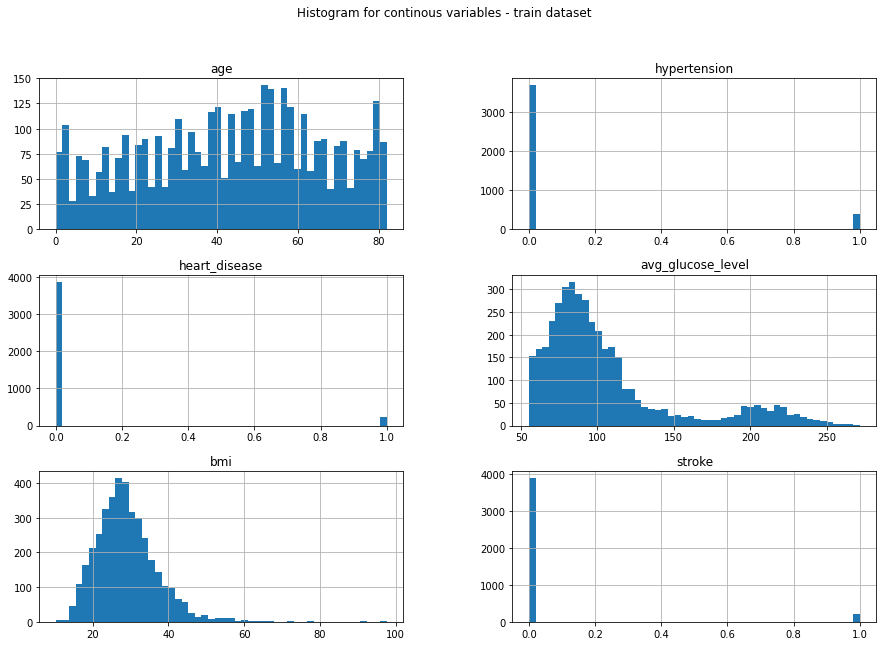

In [15]:
stroke_df.drop(['id'], axis=1).hist(bins=50, figsize=(15,10), histtype='bar')
plt.suptitle('Histogram for continous variables - train dataset')
plt.show()

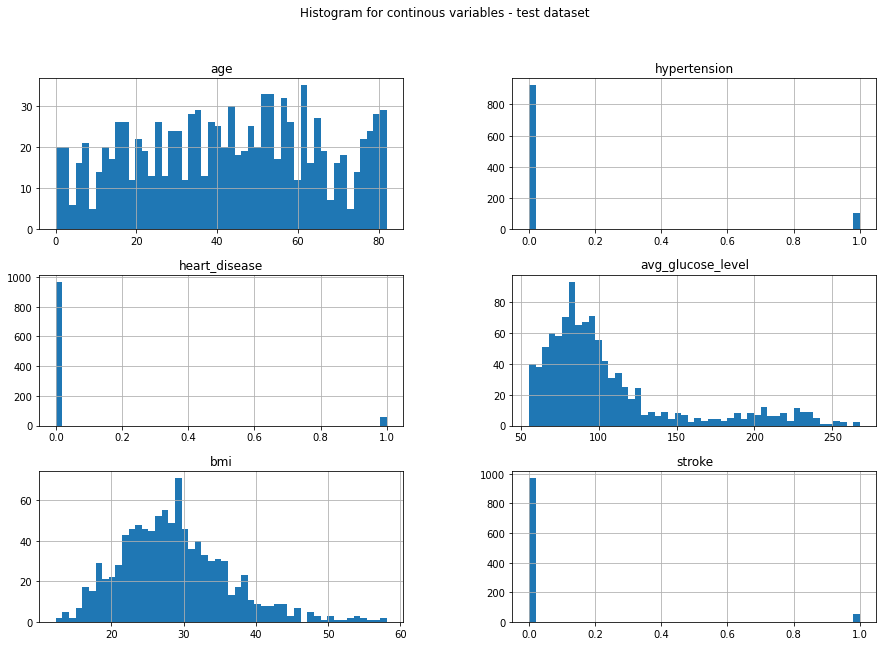

In [16]:
stroke_test_df.drop(['id'], axis=1).hist(bins=50, figsize=(15,10), histtype='bar')
plt.suptitle('Histogram for continous variables - test dataset')
plt.show()

*   Heart_disease, hypertension and stroke seem to mantain the same proportions. 
*   The age and average glucose also seem to maintain almost the same shape, with no significant differences
*   **The body mass index ranges seem to differ quite significnatly**: in the test dataset, only BMI values up to ~60 appear, whereas in the training dataset we can see even a few BMI values up to ~100. Knowning that a BMI of 35 is elrady considered severely obese, the >60 values may be considered **outliers** and should be removed from the dataset in the cleaning process.


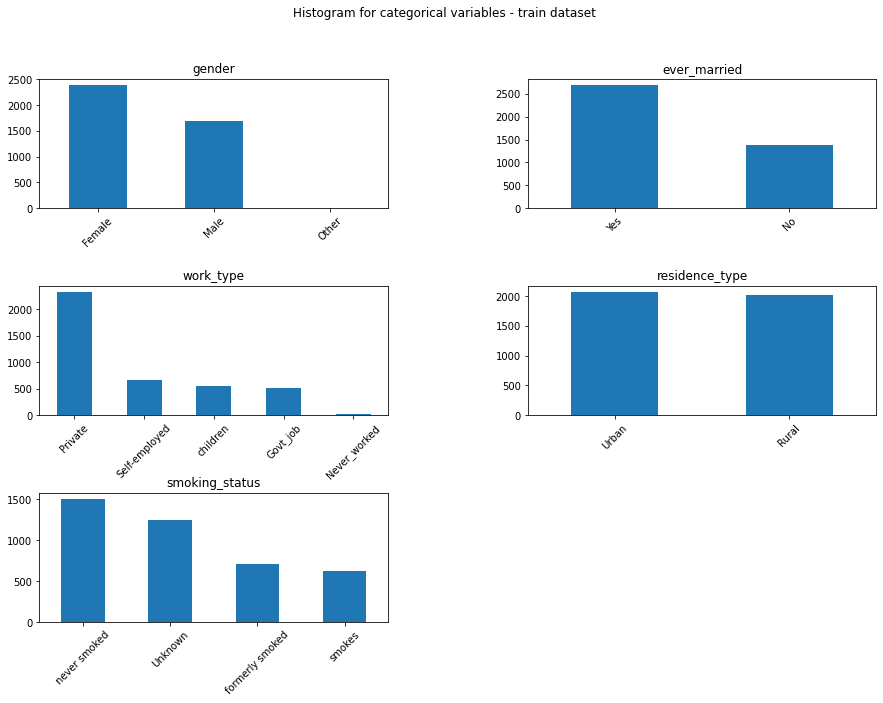

In [17]:
plt.suptitle('Histogram for categorical variables - train dataset')
generate_distribution_subplots_for_categorical_variables(stroke_df)
plt.show()

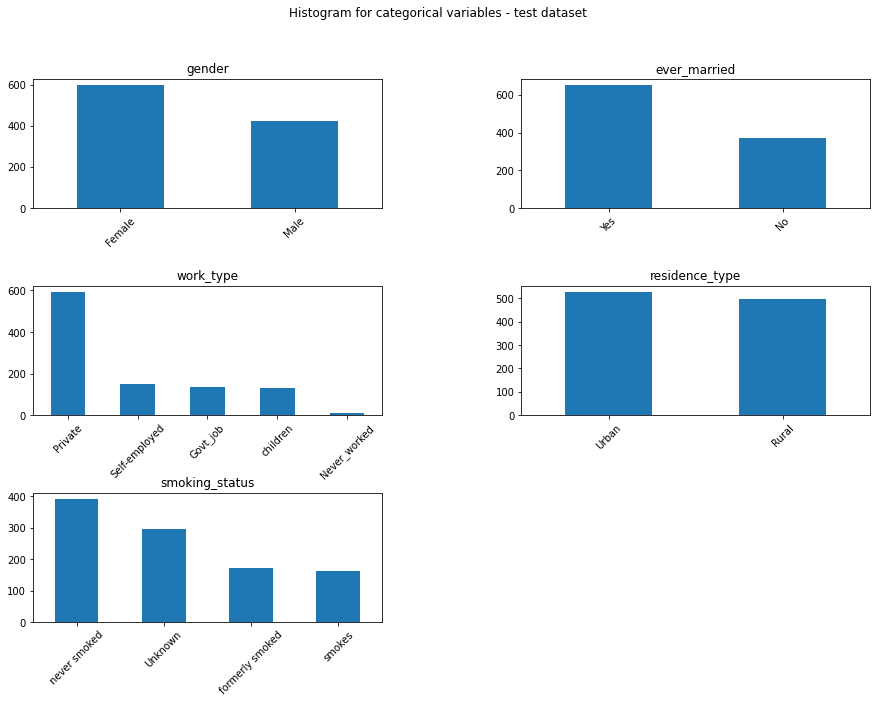

In [18]:
plt.suptitle('Histogram for categorical variables - test dataset')
generate_distribution_subplots_for_categorical_variables(stroke_test_df)
plt.show()

We do not have other as a gender in the test dataframe, since we have too few entries with that value. Even if never_worked values from work_type are very few we still have some values in the test set. We should see how we handle those values when we will perform data cleaning.

## Initial Data Analysis

The goal of the following section is to
*   get to know our data: 
    * the range/value set and distribution of ecah variable
    * how each variable is related to the target ' stroke'
*   observe what features require a cleaning

Note that this initial analysis does not address correlations yet.

In [19]:
stroke_df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,3918.000000,4088.000000
mean,36547.666585,43.353288,0.097114,0.054061,106.317167,28.922180,0.048679
std,21238.482961,22.596816,0.296148,0.226165,45.259652,7.928378,0.215223
min,77.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17621.500000,26.000000,0.000000,0.000000,77.312500,23.600000,0.000000
50%,36963.500000,45.000000,0.000000,0.000000,91.945000,28.000000,0.000000
75%,54787.750000,61.000000,0.000000,0.000000,114.197500,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### Analysing the individual features

#### Helper functions

In [20]:
def plot_continuous_variable_distribution(df, var_series, var_name, title):
  sns.displot(data=df, x=var_name, kde=True, height=def_plot_length)
  # median
  disp = 0.4
  plt.axvline(x=var_series.median(),
              color='red')
  plt.text(var_series.median() + disp, 0, "50%", rotation = 90)
  # 25%
  plt.axvline(x=var_series.quantile(0.25),
              color='red')
  plt.text(var_series.quantile(0.25) + disp, 0, "25%", rotation = 90)
  # 75%
  plt.axvline(x=var_series.quantile(0.75),
              color='red')
  plt.text(var_series.quantile(0.75) + disp, 0, "75%", rotation = 90)
  # mean
  plt.axvline(x=var_series.mean(),
              color='green')
  plt.text(var_series.mean() + disp, 0, "Mean", rotation = 90)

  plt.title(title, size=def_title_size)

In [21]:
def plot_continuous_variable_stroke_ratio(df, var_name, no_quantiles, title, xticks_rotation=0, nr_bar_decimals=2, nr_tick_decimals = 2):
  stroke_df_group = df.copy()
  stroke_df_group[var_name+"_group"] = pd.qcut(stroke_df_group[var_name], q=no_quantiles)
  stroke_ratio_per_var_group = stroke_df_group.groupby([var_name+"_group"]).apply(lambda age_group: age_group["stroke"].sum() / age_group["stroke"].count())
  fig, ax = plt.subplots(figsize=def_fig_size)
  pal = sns.color_palette("rocket", len(stroke_ratio_per_var_group))
  rank = stroke_ratio_per_var_group.argsort().argsort() 

  plots = sns.barplot(x = stroke_ratio_per_var_group.index, y = stroke_ratio_per_var_group.values, ax = ax, palette = np.array(pal[::-1])[rank])
  print(type(stroke_ratio_per_var_group.index[0]))

  # Iterating over the bars one-by-one to add annotations
  for bar in plots.patches:
      plots.annotate(format(bar.get_height(), '.{0}f'.format(nr_bar_decimals)),
                    (bar.get_x() + bar.get_width() / 2,
                      bar.get_height()), ha='center', va='center',
                    size=8, xytext=(0, 8),
                    textcoords='offset points')
      
  xlabels = stroke_ratio_per_var_group.index.map(lambda interval : "({left:.{nr_dec}f}, {right:.{nr_dec}f}".format(nr_dec = nr_tick_decimals, left = interval.left, right = interval.right))
  ax.set_xticklabels(xlabels)
      
  plt.xticks(rotation=xticks_rotation)
  plt.title(title, size = def_title_size)


In [22]:
def plot_categorical_variable_stroke_ratio(df, var_name, title, nr_bar_decimals=2):
  stroke_cnt = df.groupby([var_name, 'stroke']).count()
  stroke_cnt = stroke_cnt.loc[:, :, ] .reset_index().pivot(index=var_name, columns='stroke', values='id')
  stroke_cnt['stroke_ratio'] = stroke_cnt[1] / (stroke_cnt[0] + stroke_cnt[1])

  fig, ax = plt.subplots(figsize=(10, 6))
  pal = sns.color_palette("rocket", len(stroke_cnt))
  rank = stroke_cnt['stroke_ratio'].argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638
  plots = sns.barplot(x = stroke_cnt.index, y = stroke_cnt['stroke_ratio'], ax = ax, palette = np.array(pal[::-1])[rank])

  # Iterating over the bars one-by-one to add annotations
  for bar in plots.patches:
      plots.annotate(format(bar.get_height(), '.{0}f'.format(nr_bar_decimals)),
                    (bar.get_x() + bar.get_width() / 2,
                      bar.get_height()), ha='center', va='center',
                    size=15, xytext=(0, 8),
                    textcoords='offset points')

  plt.title(title, size = def_title_size)

#### Gender

First of all, we should analyze the gender types that we have in our dataset.

In [23]:
gender_value_counts = stroke_df.gender.value_counts()
gender_value_counts

Female    2395
Male      1692
Other        1
Name: gender, dtype: int64

We only have one value for other gender type, it might not help us with our prediction.

In [24]:
stroke_df.loc[stroke_df['gender']=='Other']


,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


Having a pie chart will help us visualize better the ratio between females and males. We can observe that this ratio is not very balanced, having 59% females and only 41% male.

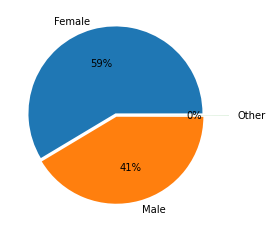

In [25]:
explode = [0.02,0.02,0.3]
plt.pie(gender_value_counts.array, labels=gender_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.show()

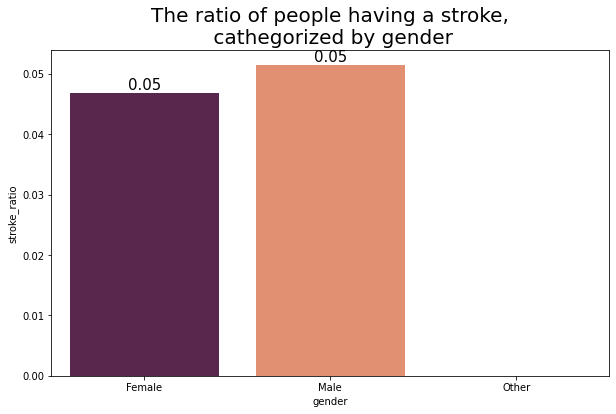

In [26]:
plot_categorical_variable_stroke_ratio(stroke_df, "gender", "The ratio of people having a stroke,\n cathegorized by gender")

The stroke events are almost evenly split among men and woman, but the ratio of men that had stroke is slightly greater than the ratio of woman, in our dataset. In general it is expected that stroke events are more frequently in woman, as they tend to live longer ([see article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2665267/)).

#### Age

In [27]:
stroke_df.age.describe()

count    4088.000000
mean       43.353288
std        22.596816
min         0.080000
25%        26.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64



*   **median age: 45.0**
  *   considering that the **median age in the world is only 30.63**, this dataset seems to describe an **aging population**, probably from one of the highly developed countries
  *   note that only 5 countries in he world have a median age >= 5 (Italy, Saint Pierre and Miquelon, Germany, Japan and Monaco)
  *   source: [worldpopulationreview.com](https://worldpopulationreview.com/country-rankings/median-age)



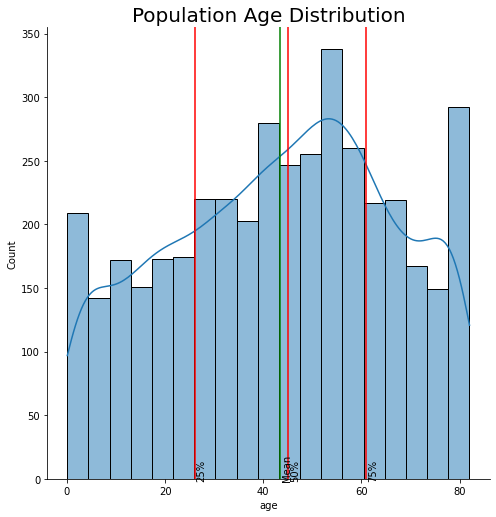

In [28]:
plot_continuous_variable_distribution(stroke_df, stroke_df.age, "age", "Population Age Distribution")

Text(0.5, 1.0, 'Age Distribution by Stroke Status')

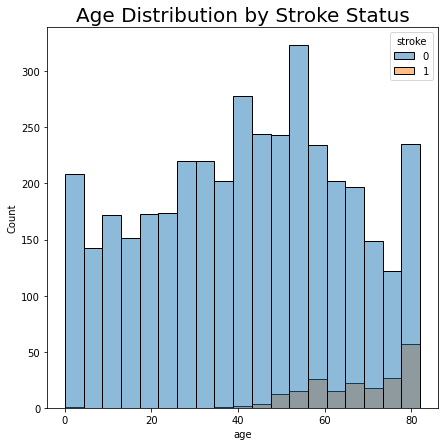

In [29]:
fig, ax = plt.subplots(figsize=def_fig_size)
sns.histplot(data=stroke_df, x="age", hue="stroke", ax=ax)
plt.title("Age Distribution by Stroke Status", size = def_title_size)

<class 'pandas._libs.interval.Interval'>


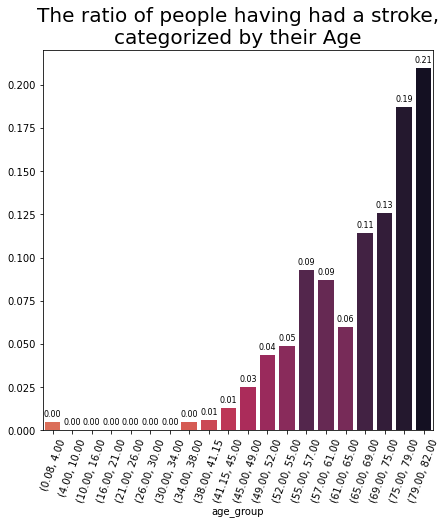

In [30]:
plot_continuous_variable_stroke_ratio(stroke_df, "age", 20, "The ratio of people having had a stroke,\ncategorized by their Age", 70)

As expected, the ratio of the population who had a stroke increases by age.

#### Hypertension

From all the persons in our dataset, we can see that only 10% have had hypertension. Globally, **an estimated 26% of the world’s population** (972 million people) has hypertension.

https://www.medscape.com/answers/241381-7614/what-is-the-global-prevalence-of-hypertension-high-blood-pressure

In [31]:
hypertension_value_counts = stroke_df.hypertension.value_counts()
hypertension_value_counts

0    3691
1     397
Name: hypertension, dtype: int64

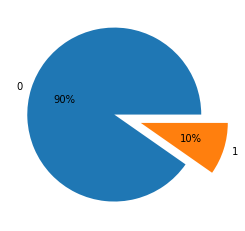

In [32]:
explode = [0.02,0.3]
plt.pie(hypertension_value_counts.array, labels=hypertension_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.show()

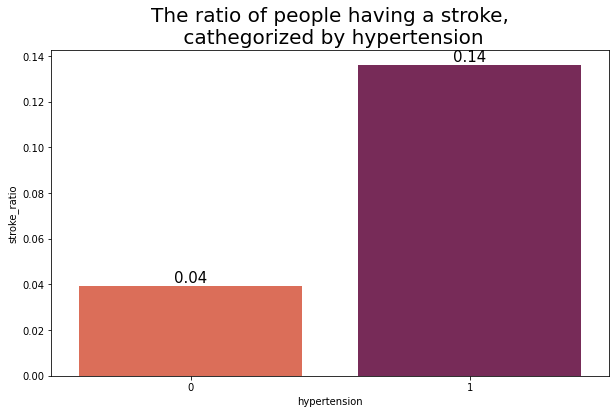

In [33]:
plot_categorical_variable_stroke_ratio(stroke_df, "hypertension", "The ratio of people having a stroke,\n cathegorized by hypertension")

As expected, a stroke is more common for people that suffer from hypertension than the rest of the people.

#### Heart Disease

The feeature shows whether a person has (1) os hasn't got (0) any herat diseases.

In [34]:
heart_disease_value_counts = stroke_df.heart_disease.value_counts()
heart_disease_value_counts

0    3867
1     221
Name: heart_disease, dtype: int64

Only 276 people out of 5110 had a heart disease.

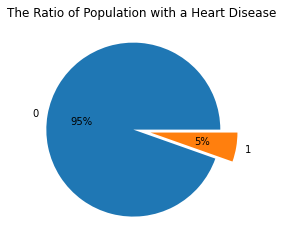

In [35]:
explode = [0.1] * heart_disease_value_counts.count()
plt.pie(heart_disease_value_counts.array, labels=heart_disease_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.title("The Ratio of Population with a Heart Disease")
plt.show()

The people with a heart disease represent 5% of the population.

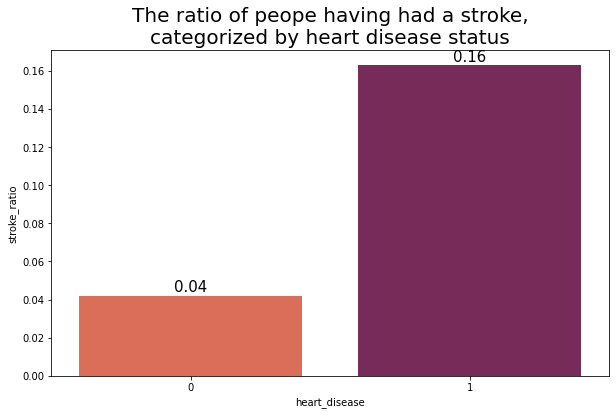

In [36]:
plot_categorical_variable_stroke_ratio(stroke_df, "heart_disease", "The ratio of peope having had a stroke,\ncategorized by heart disease status")

As expected, the ratio of people who had a stroke is much higher (17% vs 4%) among people with a heart disease.

#### Marital Status

The values for marital status are 'Yes' or 'No' values. We prefer to have 0 or 1 values instead.

In [37]:
ever_married_value_counts = stroke_df.ever_married.value_counts()
ever_married_value_counts

Yes    2700
No     1388
Name: ever_married, dtype: int64

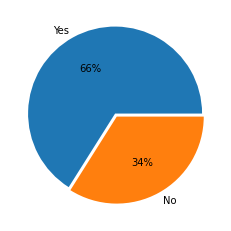

In [38]:
explode = [0.02,0.02]
plt.pie(ever_married_value_counts.array, labels=ever_married_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.show()

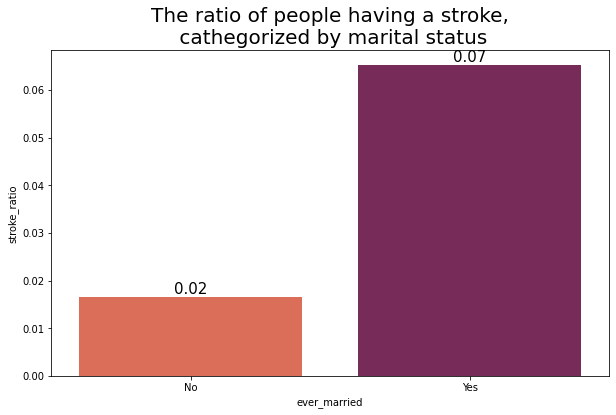

In [39]:
plot_categorical_variable_stroke_ratio(stroke_df, "ever_married", "The ratio of people having a stroke,\n cathegorized by marital status")

This plot shows that stroke is more common in people who are married, but this may be due to the fact that older people (that are at a higher risk of having a stroke) in general are married. 

#### Work Type

We have identified several work types i.e. private, self-employed, government job, children and never worked.

In [40]:
work_type_value_counts = stroke_df.work_type.value_counts()
work_type_value_counts

Private          2332
Self-employed     667
children          554
Govt_job          522
Never_worked       13
Name: work_type, dtype: int64

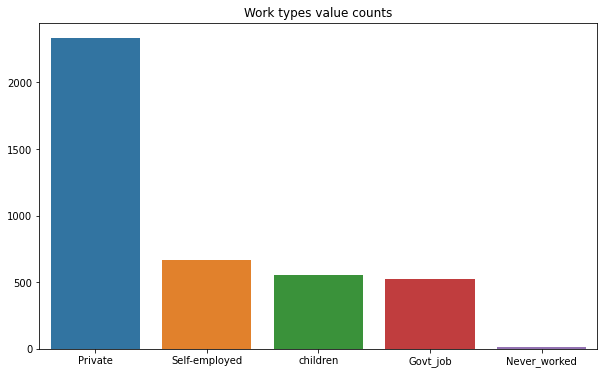

In [41]:
plt.figure(figsize=(10,6))
plt.title("Work types value counts")
sns.barplot(x=work_type_value_counts.index, y=work_type_value_counts.array)
plt.show()

The values children and never worked might be corellated since most children don't work. Let's see how many never worked values are for people with an age greater than 18.

In [42]:
stroke_df.loc[(stroke_df['work_type'] == 'Never_worked') & (stroke_df['age'] >= 18)]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
4772,13960,Female,18.0,0,0,No,Never_worked,Urban,97.65,21.5,Unknown,0
603,61408,Male,23.0,0,0,No,Never_worked,Urban,125.26,18.7,never smoked,0
886,13948,Female,19.0,0,0,No,Never_worked,Urban,86.96,25.8,never smoked,0
2917,11702,Female,18.0,0,0,No,Never_worked,Urban,82.36,22.7,Unknown,0


There are only four values for never worked people that aren't children. They also didn't have a stroke. We might consider deleting them in the data cleaning process.

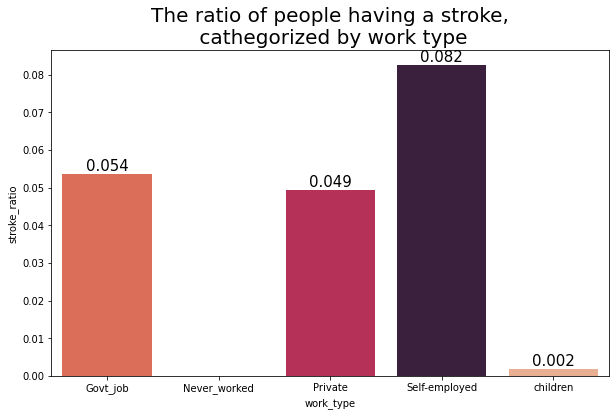

In [43]:
plot_categorical_variable_stroke_ratio(stroke_df, "work_type", "The ratio of people having a stroke,\n cathegorized by work type", 3)

We can observe that we have very few strokes among children and never_worked (which are mostly children). The stroke events are evenly split among government jobs and private work types, but self-employed people tend to have more strokes. Accordingly to this [study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7287446/), **self-employed people might have a higher risk of having a cardiovascular disease**, which might lead to a stroke, but the studies made about this subject are very limited.

#### Residence Type

The feature shows whether the person lives in a rural or urban area.

In [44]:
residence_type_value_counts = stroke_df.residence_type.value_counts()
residence_type_value_counts

Urban    2069
Rural    2019
Name: residence_type, dtype: int64

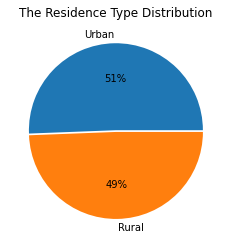

In [45]:
explode = [0.01] * residence_type_value_counts.count()
plt.pie(residence_type_value_counts.array, labels=residence_type_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.title("The Residence Type Distribution")
plt.show()

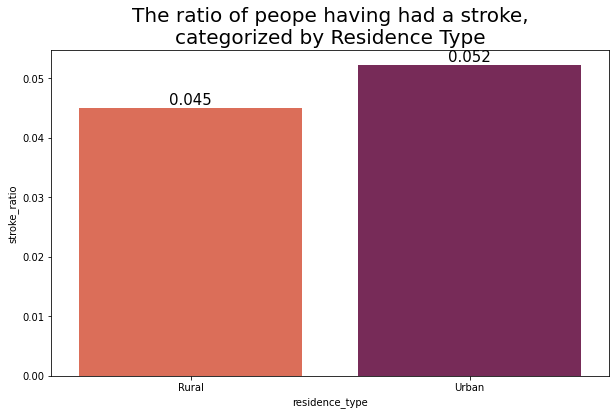

In [46]:
plot_categorical_variable_stroke_ratio(stroke_df, "residence_type", "The ratio of peope having had a stroke,\ncategorized by Residence Type", 3)

The data shows that people living in an urban area have a slightly higher chance for a stroke (5.2% vs 4.5%), but the residence type does not seem to be a significant factor in one's chance for a stroke.

The people are fairly distributed between twose living in urban and in rural areas.

#### Average Glucose Level

This feature shows the average glucose level in a person's blood, in mg/dL.

In [47]:
stroke_df.avg_glucose_level.describe()

count    4088.000000
mean      106.317167
std        45.259652
min        55.120000
25%        77.312500
50%        91.945000
75%       114.197500
max       271.740000
Name: avg_glucose_level, dtype: float64

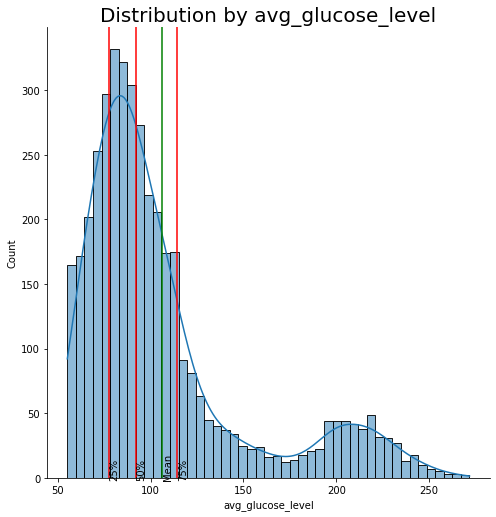

In [48]:
plot_continuous_variable_distribution(stroke_df, stroke_df.avg_glucose_level, "avg_glucose_level", "Distribution by avg_glucose_level")

Text(0.5, 1.0, 'Avg Glucose Level Distribution by Stroke Status')

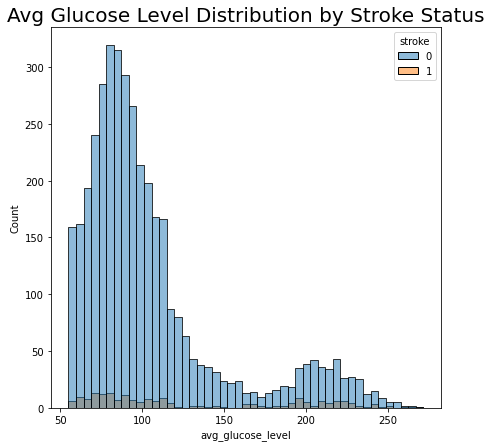

In [49]:
fig, ax = plt.subplots(figsize=def_fig_size)
sns.histplot(data=stroke_df, x="avg_glucose_level", hue="stroke", ax=ax)
plt.title("Avg Glucose Level Distribution by Stroke Status", size = def_title_size)

<class 'pandas._libs.interval.Interval'>


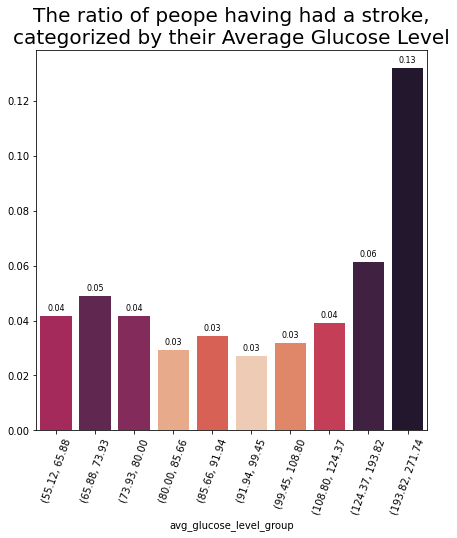

In [50]:
plot_continuous_variable_stroke_ratio(stroke_df, "avg_glucose_level", 10, "The ratio of peope having had a stroke,\ncategorized by their Average Glucose Level", 70)

As expected, both people with a very low and with a very high blood glucose level are more likely to have a stroke than the people with a regular glucose level. 

General medical guidelines state that a glucose level of less than 100mg/dL is normal after not eating for more than 8 hours, and a glucose level of less than 140mg/dL is normal after not eating for at least 2 hours ([see this analysis](https://https://www.webmd.com/diabetes/how-sugar-affects-diabetes)). These guidelines are confirmed by the above plot, which shows that


*   an average glucose level lower than 80mg/dL may increase the chance for a stroke, by ~30%
*   an average glucose level higher than 124mg/dL may dramatically increase the chance for a stroke, by more than 200%



#### Body Mass Index

There also might be children in our dataset, we do not want to consider them for the adult BMI analysis since the way their BMI is interpreted is different than for adults.

In [51]:
adults_only_df = stroke_df.loc[stroke_df['age']>=18]
adults_only_df.bmi.describe()

count    3259.000000
mean       30.480700
std         7.278777
min        11.300000
25%        25.500000
50%        29.300000
75%        34.200000
max        92.000000
Name: bmi, dtype: float64

A BMI of: 

* less than 18.5 is Underweight
* 18.5 - 25 is Normal	
* 25 - 30 is Overweight	
* 30 - 35 is Moderate Obesity
* 35 - 40 is Severe Obesity
* 40 - 46 is Very Severe Obesity
* 45-50 is Morbid
* 50-60 is Super
* greater then 60 is Hyper Obesity 
 
Data extracted from this ([article](https://www.topdoctors.co.uk/medical-dictionary/body-mass-index-bmi)).
 
 The fact that we have a mean value of 30 means that the dataset tends to describe a population that is slightly more overweight. 

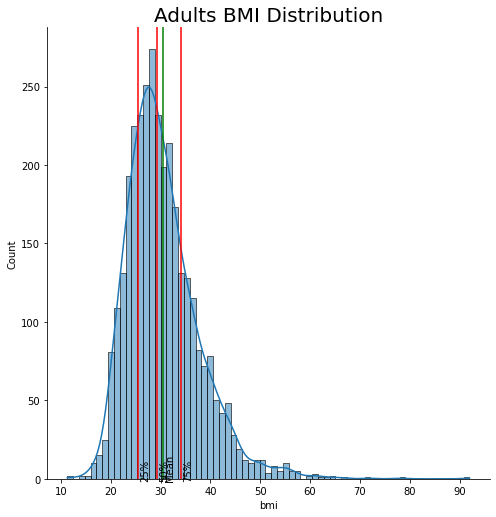

In [52]:
plot_continuous_variable_distribution(adults_only_df, adults_only_df.bmi, "bmi", "Adults BMI Distribution")

First, we should notice, that the distribution is very right-skewed: we have a few extremely larger BMI values: despite values above 35 are already considered a severe obesity, and those between 50-60 are marked as 'super obesity' we have a few **outliers** with values well above 60. We may consider removing these values, since we do not have enough data for reliable preidctions in case of morbid- and super-obesity.

The data from above might be better understood if we would classify the BMI value by what it represents i.e. underweight, normal, overweight etc.

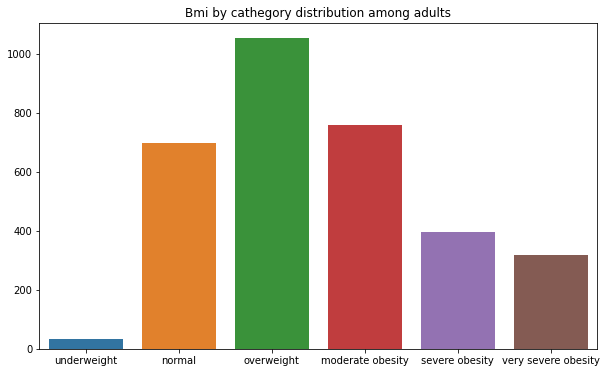

In [53]:
bmi_categ_list = ['underweight', 'normal', 'overweight',
              'moderate obesity', 'severe obesity', 'very severe obesity']
stroke_df_with_bmi_categ = adults_only_df.copy()
stroke_df_with_bmi_categ.bmi = pd.cut(stroke_df_with_bmi_categ.bmi,
                                      bins=[0, 18.5, 25, 30, 35, 40, 100],
                                      labels=bmi_categ_list)

bmi_categ_value_counts = stroke_df_with_bmi_categ.bmi.value_counts()

plt.figure(figsize=(10,6))
plt.title("Bmi by cathegory distribution among adults")
sns.barplot(x=bmi_categ_value_counts.index, y=bmi_categ_value_counts.array, order=bmi_categ_list)
plt.show()


The distrubution based on the BMI classifications is not very balanced, as is having more cases of overweight and obese people than people with normal weight. 

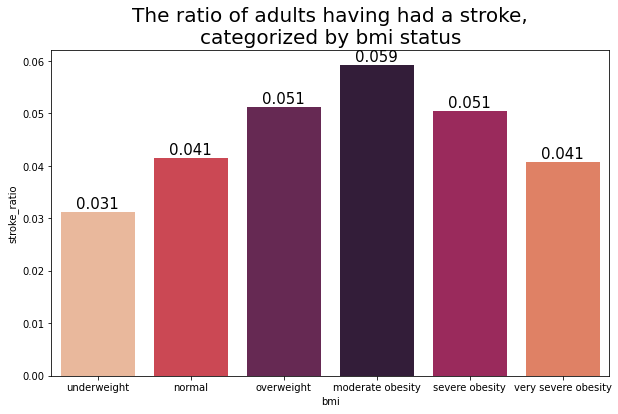

In [54]:
plot_categorical_variable_stroke_ratio(stroke_df_with_bmi_categ, "bmi", 
                                       "The ratio of adults having had a stroke,\ncategorized by bmi status",3)

The adults that are overweight or suffer from obesity are more likely to have a stroke. The plot also shows that a stroke is more common in our dataset among people that are overweight, than those that are suffering from obesity, but the difference is not big.

Now let's analyze how the BMI values for children.
 

In [55]:
children_only_df = stroke_df[stroke_df['age']<18]
children_only_df.bmi.describe()

count    659.000000
mean      21.214719
std        6.351494
min       10.300000
25%       17.500000
50%       19.800000
75%       23.250000
max       97.600000
Name: bmi, dtype: float64

We can observe that the mean value for children is 21, which is less than the one for adults, as we should expect.

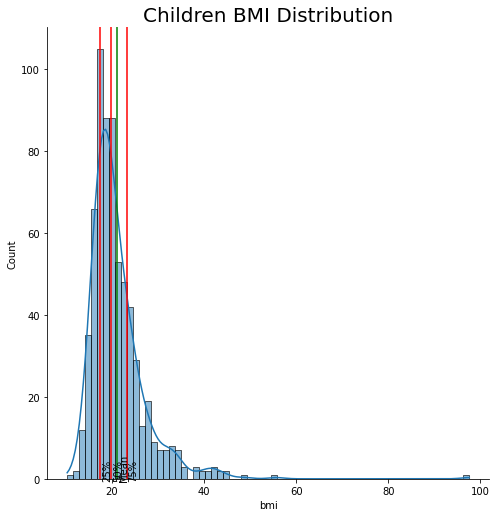

In [56]:
plot_continuous_variable_distribution(children_only_df, children_only_df.bmi, "bmi", "Children BMI Distribution")

As expected, the whole distribution of bmi for children lays to the left, having in general smaller values for bmi than the values that we have for adults.

In [57]:
children_only_df[children_only_df.stroke == 1]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1


From all the 659 children in our dataset, only one had a stroke, so the ratio of children that had a stroke is going to be very close to zero, no matter the bmi.

#### Smoking Status

This feature shows whether a person


*   smokes
*   formerly smoked
*   never smoked
*   their smoking status is unknown



In [58]:
smoking_value_counts = stroke_df.smoking_status.value_counts()
smoking_value_counts

never smoked       1501
Unknown            1247
formerly smoked     714
smokes              626
Name: smoking_status, dtype: int64

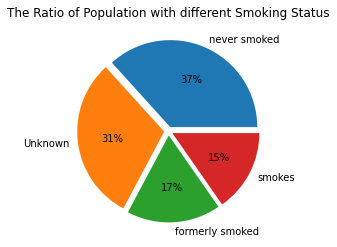

In [59]:
explode = [0.05] * smoking_value_counts.count()
plt.pie(smoking_value_counts.array, labels=smoking_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.title("The Ratio of Population with different Smoking Status")
plt.show()

We can see that 31% of the data is missing. We can't drop 30% of the data, so we should replace the 'Unknown' values somehow.

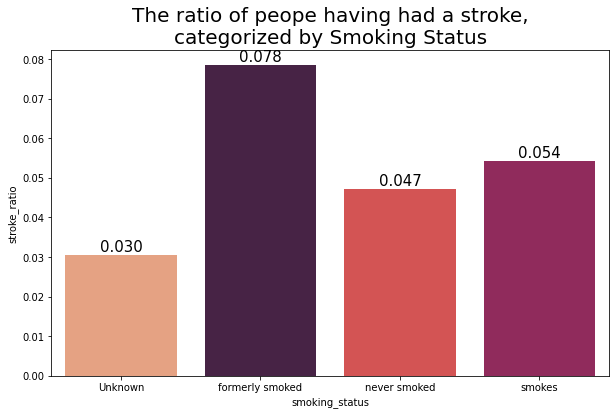

In [60]:
plot_categorical_variable_stroke_ratio(stroke_df, "smoking_status", "The ratio of peope having had a stroke,\ncategorized by Smoking Status", 3)

Unexpectedly, the ratio of people who had a stroke is higher among former smokers than among current smokers. 

This may be explained by the facts that:


*   those who have formerly smoked may be older
*   many of those who are smoking now may have smoked for less time




### The label: Stroke

The most imporant part is knowing the number of people that had stroke in our dataset, since this is what we are trying to predict.

In [61]:
stroke_value_counts = stroke_df.stroke.value_counts()
stroke_value_counts

0    3889
1     199
Name: stroke, dtype: int64

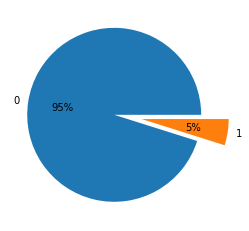

In [62]:
explode = [0.02,0.3]
plt.pie(stroke_value_counts.array, labels=stroke_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.show()

Only 5% of people in our dataset have had a stroke. 

## Correlations


#### Helper functions

In [63]:
def subplots_for_continuous_variable_stroke_ratio(df, var_name, no_quantiles, axes, title, xticks_rotation=70, nr_bar_decimals=2, nr_tick_decimals = 2):
  stroke_df_group = df.copy()
  stroke_df_group[var_name+"_group"] = pd.qcut(stroke_df_group[var_name], q=no_quantiles)
  stroke_ratio_per_var_group = stroke_df_group.groupby([var_name+"_group"]).apply(lambda age_group: age_group["stroke"].sum() / age_group["stroke"].count())
  pal = sns.color_palette("rocket", len(stroke_ratio_per_var_group))
  rank = stroke_ratio_per_var_group.argsort().argsort() 
  plots = sns.barplot(x = stroke_ratio_per_var_group.index, y = stroke_ratio_per_var_group.values, ax = axes, palette = np.array(pal[::-1])[rank])

  # Iterating over the bars one-by-one to add annotations
  for bar in plots.patches:
      plots.annotate(format(bar.get_height(), '.{0}f'.format(nr_bar_decimals)),
                    (bar.get_x() + bar.get_width() / 2,
                      bar.get_height()), ha='center', va='center',
                    size=8, xytext=(0, 8),
                    textcoords='offset points')
      
  xlabels = stroke_ratio_per_var_group.index.map(lambda interval : "({left:.{nr_dec}f}, {right:.{nr_dec}f}".format(nr_dec = nr_tick_decimals, left = interval.left, right = interval.right))
  axes.set_xticklabels(xlabels, rotation = xticks_rotation)
  axes.set_title(title)



#### Computing and Analysing Correlations

Since we have quite a lot of categorical, and more than that, nominal variables, Pandas's `corr()` function for computing correlations doesn't seem well-suited for our use case, because it deals with numerical variables only. 

To overcome this limitation, we'll use Dython's `associations()` function, which can treat correlations between any variable types ([source](http://shakedzy.xyz/dython/modules/nominal/))

*   **numerical - numerical correlations** are computed based on **Pearson's coefficient**. This measures the strength of a linear relationship between the two variables. Range: [-1, 1]. Further details are not discussed, as Pearson's coefficient is assumed to be known by the reader.

*   **nominal - nominal correlations** are computed based on **Cramer's V**, a generalized Phi's Coefficient. Range: [-1, 1]. 

     * *Phi's Coefficient*: also known as Matthews correlation coefficient, is a measure of association between two binary variables. It is in fact a special case of Pearson's coefficient (Pearson's coefficient calculated for 2 binary variables will result in Phi's coefficient).

      [source](http://www.pmean.com/definitions/phi.htm)

      Given the distribution of two binary variables X and Y:
      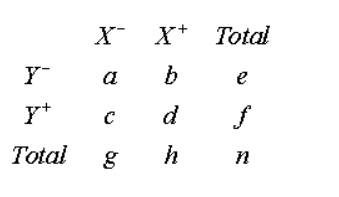

    Phi's coefficient is computed as 
  
    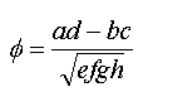

     Thus, we can say that based on Phi's Coefficient, X and Y are positively associated if most of the entries fall on the main diagonal (resulting in a coefficient > 0, and > 0.6 for a strong positive association), and negatively associated if they fall outside the diagonal (resulting in a coefficient < 0, and < -0.6 for a strong negative association)

    * *Cramer's V* is a generalization of Phi's coefficient, in that it works not only for binary but also for multi-valued nominal variables. Differently from Pearon's and Phi's coefficient, it's range is [0, 1] only. 

      [source](https://www.spss-tutorials.com/cramers-v-what-and-why/)

    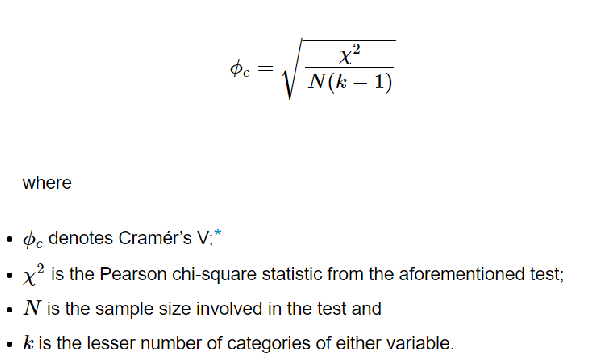

     Interpretation: based on [IBM's guideline](https://www.jmp.com/en_be/statistics-knowledge-portal/chi-square-test.html), 
      *    V < 0.2 is considered to show a weak association
      *    V in [0.2, 0.6] is considered a moderate association
      *    V > 0.6 is considered a strong association

*   **nominal - numerical correlations** are computed based on **Correlation Ratios**, which is a measure of the relationship between the statistical dispersion in the individual categories of the nominal variable and the statistical dispersion in the entire population. Similarly to Cramer's V, it's range is [0, 1].

    [source](https://en.wikipedia.org/wiki/Correlation_ratio)

    It's square can be computed as 
    
    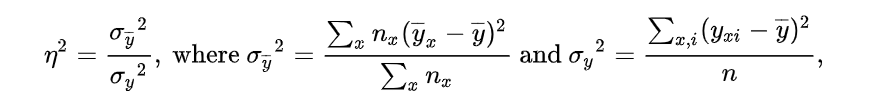

    which represents the variance of the category means divided by the variance of all samples (x denotes a category, y an observation).

    Interpretation: 

      *    eta close to 1 means that the overall dispersion is mostly due to the dispersion between categories. Marks a strong association.
      *    eta close to 0 means that the overall dispersion is mostly due to the dispersion within the individual categories

In [64]:
pip install dython

     |████████████████████████████████| 11.2 MB 9.5 MB/s 
     |████████████████████████████████| 38.1 MB 9.8 MB/s 
     |████████████████████████████████| 899 kB 41.4 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [66]:
from dython.nominal import associations
from dython.nominal import identify_nominal_columns
from dython.nominal import cluster_correlations
categorical_features=identify_nominal_columns(stroke_df)

##### Correlations between all features

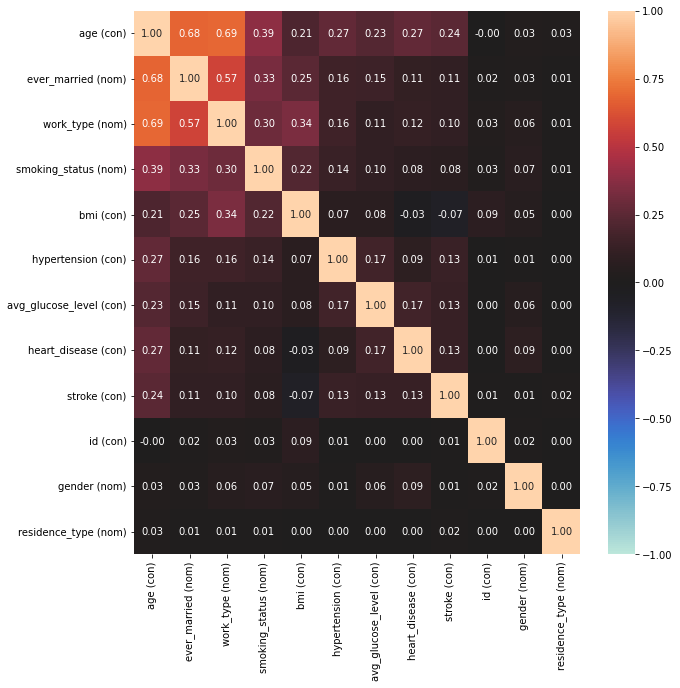

In [67]:
correlations = associations(stroke_df, compute_only=True, figsize=(10, 10), mark_columns=True)['corr']
correlations, _ = cluster_correlations(correlations)
plt.figure(figsize=(10, 10))
sns.heatmap(correlations, annot=True, vmin=-1, vmax=1, cmap="icefire", fmt=".2f")

##### Correlations with the label


In [68]:
correlations["stroke (con)"].sort_values(ascending = False)

stroke (con)               1.000000
age (con)                  0.243404
hypertension (con)         0.133109
heart_disease (con)        0.126883
avg_glucose_level (con)    0.125328
ever_married (nom)         0.106979
work_type (nom)            0.103371
smoking_status (nom)       0.075112
residence_type (nom)       0.016559
id (con)                   0.013915
gender (nom)               0.011224
bmi (con)                 -0.065792
Name: stroke (con), dtype: float64

##### Observations

**Correlations with the label (stroke)**

From the heatmap we can get the features that are showing some corellation with stroke (considered the values > 0.1)
*   age
*   hypertension
*   heart_disease
*   ever_married
*   avg_glucose_level
*   ever_married
*   work_type

However, based on the above formulas, actually none of these correlations is strong enough to be a promision feature for prediction on its own. 

Moreover, the variables that have a correlation < 0.1 with the stroke (smoking status, residence type, gender and bmi) seem absolutely irrelevant for the predictive model, assuming that the model is based on a linear approximation function (because correlations also show linear relationships). 

However, if we use a more complex ML model for prediction, that can combine features, than these seemingly uncorrelated features may still be relevant. 

1. Think about the smoking_status for example. We have shown in the 'Individual Feature Analysis' section, that the ratio of those who had a stroke is almost twice as high among former smokers than among non-smokers. This is a condition that a Linear Classifier cannot represent, but a Decision Tree may easily learn. 

2. Similarly, for BMI we have seen that severely obese people are almost twice as likely to suffer a stroke than the underwight ones. Such conditions could we exploited in a prediction.

The features residence_type and gender have shown minimal correlation with the label and even the individual feature analysis proved them to be almost independent of the stroke label. Thus, we may consider dropping these features entirely, if we face limitations in the computational resources avaiable for training our model and would need to simplify the model somehow. 

**Correlations between the features**

Additionaly, we can observe some correlations between the features: work type, age and ever_married seem significantly correlated between each other, and some correlation with BMI can also be observed. 

While we could consider performing a dimensionality reduction to drop some of these features, assuming that using only one of them would aready offer enough information, in practice we should try to understand what happens under the hood, why these variables are correlated.

If we check the 'Individual Feature Analysis' section again, we can easily see that work_type includes a separate category for children, and also, children can never be married. Thus, all the children are likely to have a similar age and the same work_type and marital status, which is already enough to produce some level of correlation, but is not significant when it comes to adults (it is true though, that older adults are even more likely to have been married at least once in their lifetime). In fact, we would expect the model to treat children separately (intuitively, children rarely have strokes, unless they have another illness), and consider the maritas status and work type for adults only.

#### A deeper dive into relevant correlations

##### Scatter-matrix 

Let's see the corelations that we have in more detail using a scatter matrix.

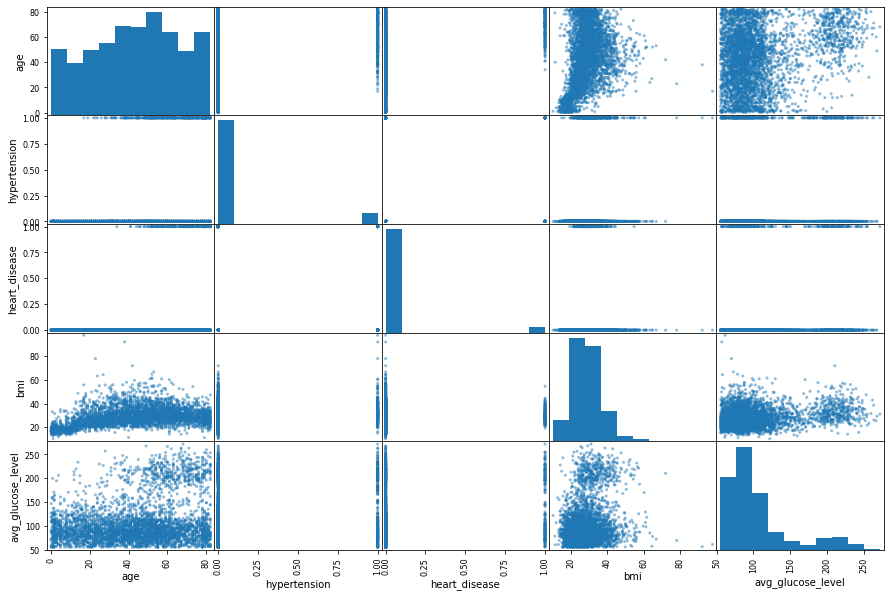

In [69]:
attributes = ["age", "hypertension", "heart_disease", "bmi", "avg_glucose_level"]
scatter_matrix(stroke_df[attributes], figsize=(15,10))
plt.show()

The above plot shows all the possible corellations between the selected attributes for analysis. Let's take the most important scatter plots and discuss them in more detail.

In [70]:
def plot_scatter_stroke(hasstroke_df, nostroke_df, var1_name, var2_name):
    plt.scatter(hasstroke_df[var1_name], hasstroke_df[var2_name], c="r", label='stroke')
    plt.scatter(nostroke_df[var1_name], nostroke_df[var2_name], c="g", alpha=0.1, label = 'no stroke')
    plt.xlabel(var1_name)
    plt.ylabel(var2_name)
    plt.legend()

In [71]:
hasstroke_df = stroke_df[stroke_df.stroke == 1]
nostroke_df = stroke_df[stroke_df.stroke == 0]

###### Age and avg_glucose_level

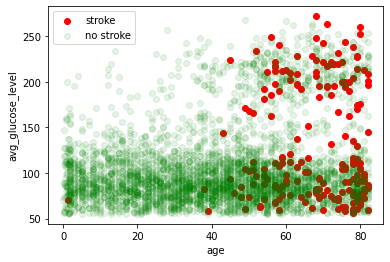

In [72]:
plot_scatter_stroke(hasstroke_df, nostroke_df, "age", "avg_glucose_level")

The above plot shows the corellation between age, average glucose level and stroke. We have seen at data visualization that average glucose level plot has two local maximum points (one between the values [75 - 120] and another onee between [190 - 250]). But it seems that from the above plot most people having a higher glucose level (190 - 250) are elderly. Those high glucose levels might indicate diabetes, and diabetes (especially type 2 diabetes) is more common for elderly people.
This plot also shows how stroke is more common for elderly people (above 40 years old), and that those having an age less than 40 are safe even if they have a high average glucose level.

###### BMI and avg_glucose_level

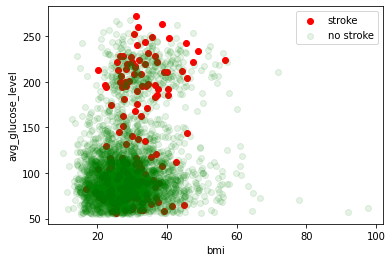

In [73]:
plot_scatter_stroke(hasstroke_df, nostroke_df, "bmi", "avg_glucose_level")

The above plot might indicate that an important part of people having a higher glucose level, that might have diabetes, tend to have a bmi of around 30, which is overweight to moderate obesity. We don't really have a high average glucose level for people that are underweight or have a normal bmi. In this plot stroke doesnt seem to have a very strong correlation with neither the bmi or the average glucose level.

###### Age and BMI

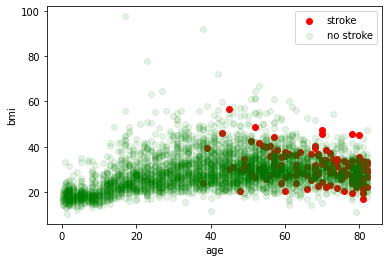

In [74]:
plot_scatter_stroke(hasstroke_df, nostroke_df, "age", "bmi")

Another correlation that we knew from the beggining, bmi is corellated with age. We can see on the above plot that children have a lower bmi, and that bmi grows as we get older. Interestingly, we dont have strokes at all happening for a bmi higher than 30 and age less then 40, meaning that even if some young people suffer from obesity even a very severe one, they aren't at a high risk for having a stroke.

##### Other relations between features 

###### Work Type and Marital Status

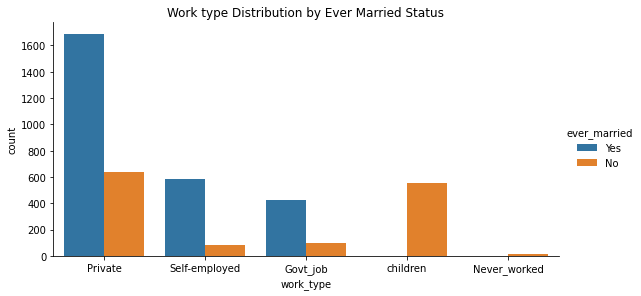

In [75]:
sns.catplot(x='work_type', hue="ever_married", kind="count", data=stroke_df, height=4, 
    aspect=2)
plt.title("Work type Distribution by Ever Married Status")
plt.show()

From the above plot, we can say that usually if you have a job chances are that you are married. 

There might be a correlation between worktype, and being married. Self-employed people are more likely to be married than those working in the private sector, according to some studies. 

But, the most important factor in the correlation seems to come from the fact that chidren (those that are not working) are not married.

###### Age and Marital Status

Text(0.5, 1.0, 'Age Distribution by Marital Status')

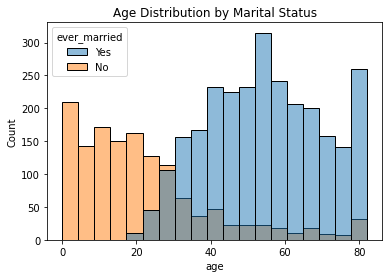

In [76]:
sns.histplot(data=stroke_df, x="age", hue="ever_married")
plt.title("Age Distribution by Marital Status")

This plot confirms our previous assumption that the correlation betwen age and marital status is caused by children not being married.

###### Age, Gender and Stroke

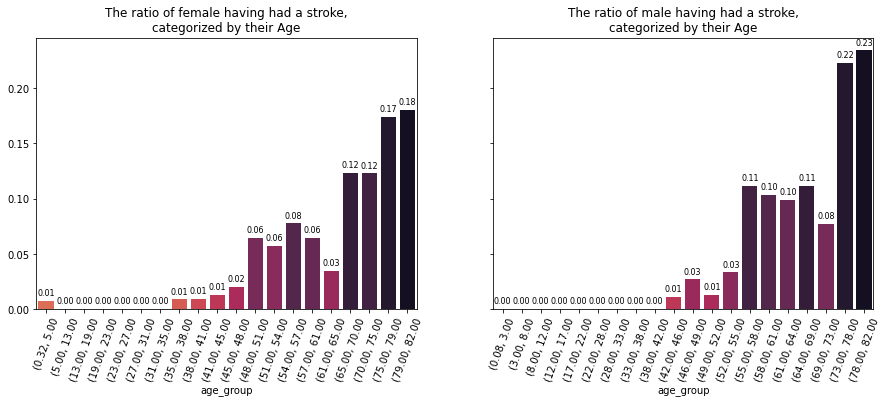

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
female_only_df = stroke_df.loc[stroke_df['gender']=='Female']
male_only_df = stroke_df.loc[stroke_df['gender']=='Male']
subplots_for_continuous_variable_stroke_ratio(female_only_df, "age", 20, axes[0], "The ratio of female having had a stroke,\ncategorized by their Age")
subplots_for_continuous_variable_stroke_ratio(male_only_df, "age", 20, axes[1], "The ratio of male having had a stroke,\ncategorized by their Age")


Women seem to start earlier than men to be predisposed for stroke, that is around 35 years old, compared to 42 years old. But overall, men seem to have a higher predisposition to having a stroke.

###### Work Type and BMI

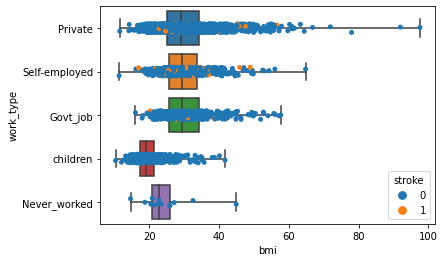

In [78]:
sns.boxplot(x="bmi", y="work_type", data=stroke_df, whis=np.inf)
sns.stripplot(x="bmi", y="work_type", hue="stroke", data=stroke_df)

This plot shows that children and people who have never worked have a significanty lower median BMI, but this may be simply caused by the fact that they are younger.

Moreover, we can observe that range of the BMIs in the 'private' work type category is larger, significantly more people seem to be both underweight and overweight. However, this may be explained with the fact that we have simply more entries in this category. In fact, the boxes show that the median, 1st and 3rd quartiles for the 'Private', 'Self-employed' and 'Govt_job' categories are really close to each other, thus, if one has a job, then the type of the job does not seem to be a good predictor of their BMI.

## Data Cleaning

### Finding the right cleaning approaches

Copy the dataset, to avoid modifying the original one.

In [79]:
stroke_df_copy = stroke_df.copy()

Let's check where we have NaN values first.

In [80]:
stroke_df_copy.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  170
smoking_status         0
stroke                 0
dtype: int64

#### Helper functions

In [81]:
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestClassifier(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

In [82]:
def get_mean_based_on_age(df):
  children_median = df[df['age'] < 18]['bmi'].median()
  adults_median = df[df['age'] >= 18]['bmi'].median()
  return children_median, adults_median

In [83]:
def clean_bmi(df, children_median, adults_median):
    df_plus = df.copy()
    
    df_plus['bmi'] = df_plus.apply(
        lambda row: children_median if ((np.isnan(row['bmi'])) & (row['age'] < 18)) else row['bmi'],
        axis=1
    )
    df_plus['bmi'] = df_plus.apply(
        lambda row: adults_median if ((np.isnan(row['bmi'])) & (row['age'] >= 18)) else row['bmi'],
        axis=1
    )
    return df_plus

The NaN values appear only for bmi, but it is not the only feature in our dataset that has to be cleaned.


#### Gender

We have seen earlier that we have a single value in our dataset that has 'Other' as a gender, so it is better to remove it as it is not enough data to make predictions based on other genders.

In [84]:
stroke_df_copy.drop(stroke_df_copy[stroke_df_copy['gender'] == 'Other'].index, inplace=True)
stroke_df_copy.gender.value_counts()

Female    2395
Male      1692
Name: gender, dtype: int64

#### Work Type

For work types, we have identified never_worked to have only 22 value counts. Some of the people that have never_worked as work type, are children. We should replace their work_status to children. To make things easier, we can directly delete the 5 rows for adults that have never_worked, and replace all remaing never_worked values with children.

In [85]:
stroke_df_copy['work_type'] = stroke_df_copy.apply(
    lambda row: "children" if ((row['work_type'] == 'Never_worked') & (row['age'] < 18)) else row['work_type'],
    axis=1
)
new_work_type_value_counts = stroke_df_copy.work_type.value_counts()
new_work_type_value_counts

Private          2331
Self-employed     667
children          563
Govt_job          522
Never_worked        4
Name: work_type, dtype: int64

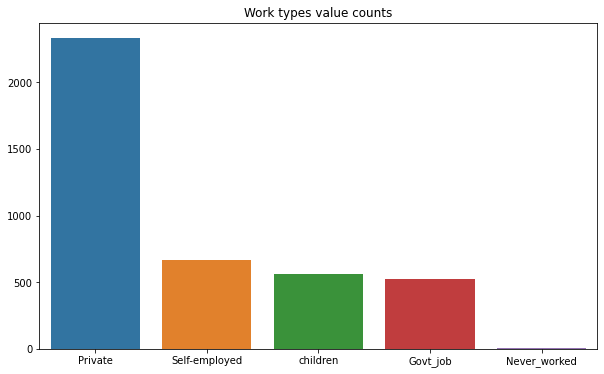

In [86]:
plt.figure(figsize=(10,6))
plt.title("Work types value counts")
sns.barplot(x=new_work_type_value_counts.index, y=new_work_type_value_counts.array)
plt.show()

#### Body Mass Index

##### Handling Outliers

As highlighted in the initial analysis of the BMI values, BMIs above 60 may be well considered outliers. Keeping them in our dataset increases the noise and may lead to overfitting. Thus, we should remove all BMI values > 60.

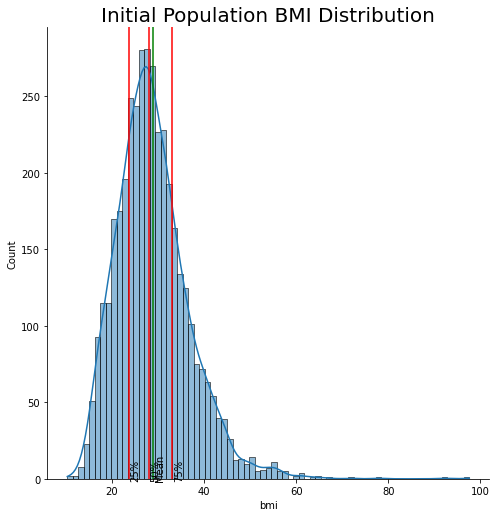

In [87]:
plot_continuous_variable_distribution(stroke_df_copy, stroke_df_copy.bmi, "bmi", "Initial Population BMI Distribution")

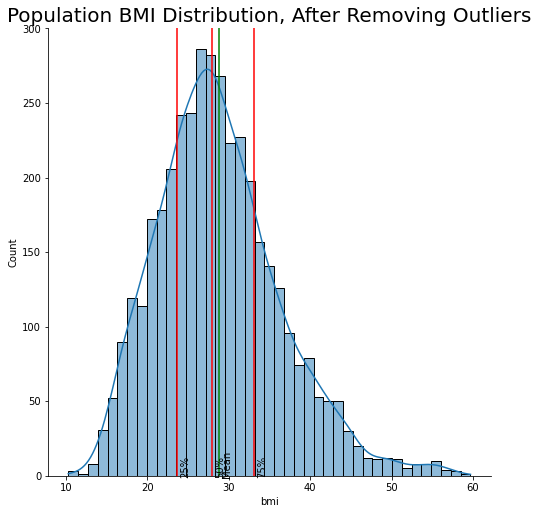

In [88]:
stroke_df_copy.drop(stroke_df_copy[stroke_df_copy['bmi'] > 60].index, inplace=True)
plot_continuous_variable_distribution(stroke_df_copy, stroke_df_copy.bmi, "bmi", "Population BMI Distribution, After Removing Outliers")

##### Handling Missing Values

To replace the missing values there are several approaches:


1.   Drop columns with missing value i.e. bmi
2.   Use a SimpleImputer with a median strategy to replace them
3.   Use a SimpleImputer with a median strategy to replace them, and add a separate feature to flag entries which had a missing bmi value
4.   Replace with median based on age, as we expect a different bmi for adults than for children
5.    USe a SimpleImputer with mean strategy

To test which approach is better we will try to predict on the changed dataset for every approach, and measure which one give us a smaller mean abolute error.



In [89]:
bmi_stroke_df = stroke_df_copy.copy()
y = bmi_stroke_df.stroke
X = bmi_stroke_df.drop(['stroke', 'id'], axis=1)
X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status
845,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked
3744,Male,15.0,0,0,No,Private,Rural,122.25,21.0,never smoked
4183,Female,67.0,0,0,Yes,Self-employed,Rural,110.42,24.9,never smoked
3409,Male,44.0,0,0,Yes,Private,Urban,65.41,24.8,smokes
284,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown


In [90]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=0)

X_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status
2480,Male,14.0,0,0,No,children,Rural,112.22,26.9,Unknown
1933,Female,70.0,0,0,Yes,Private,Urban,91.25,36.0,Unknown
4771,Male,17.0,0,0,No,Self-employed,Urban,113.85,22.9,Unknown
323,Male,53.0,0,0,Yes,Private,Rural,90.12,35.4,Unknown
4382,Female,16.0,0,0,No,Private,Rural,106.80,20.8,never smoked


In [91]:
# handling categorical variables

# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

# apply one-hot encoder on them
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

OH_transformed_train = OH_encoder.fit_transform(X_train[object_cols])
OH_transformed_valid = OH_encoder.transform(X_valid[object_cols])

column_names = OH_encoder.get_feature_names_out(object_cols)

OH_cols_train = pd.DataFrame(OH_transformed_train, columns=column_names)
OH_cols_valid = pd.DataFrame(OH_transformed_valid, columns=column_names)

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

###### Approach 1

Drop bmi column as it has missing values.

In [92]:
reduced_X_train = X_train.drop(['bmi'], axis=1)
reduced_X_valid = X_valid.drop(['bmi'], axis=1)

print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))

0.05644171779141104


This is the mean absolute error that we got. Let's see if we can improve it.

###### Approach 2

We can replace the missing values with the median value, using a Simple Imputer.

In [93]:
simple_imputer = SimpleImputer(strategy='median')
imputed_X_train = pd.DataFrame(simple_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(simple_imputer.transform(X_valid))

#imputer deleted the column names so we have to add them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

0.051533742331288344


The error is much smaller now. However, we could also try some alternatives to this.

###### Approach 3

Let's add a new column that will keep the record of whether or not the bmi was missing before we replaced it with the median.

In [94]:
simple_imputer = SimpleImputer(strategy='median')

X_train_plus = X_train.copy()
X_valid_plus = X_valid.copy()

X_train_plus['bmi_was_missing'] = X_train_plus['bmi'].isnull()
X_valid_plus['bmi_was_missing'] = X_valid_plus['bmi'].isnull()

imputed_X_train_plus = pd.DataFrame(simple_imputer.fit_transform(X_train_plus))
imputed_X_valid_plus = pd.DataFrame(simple_imputer.transform(X_valid_plus))

#imputer deleted the column names so we have to add them back
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_valid_plus.columns = X_valid_plus.columns

print(score_dataset(imputed_X_train_plus, imputed_X_valid_plus, y_train, y_valid))

0.05644171779141104


The error got bigger after this change. That might happen due to overfitting. The model is now considering the bmi_was_missing when its making the prediction, but that shouldn't be a clue to whether or not a person will have a stroke: it should only help to model to consider the bmi with a smaller weight if it was originally missing.

###### Approach 4

Another aproach would be to replace with median according to age, as the bmi for adults is different that the bmi for children. Thus adults will get a median for adults, and children will have a median for children.

In [95]:
children_median, adults_median = get_mean_based_on_age(X_train)
X_train_plus = clean_bmi(X_train, children_median, adults_median)
X_valid_plus = clean_bmi(X_valid, children_median, adults_median)
print(score_dataset(X_train_plus, X_valid_plus, y_train, y_valid))

0.051533742331288344


It seems that the mean absolute error is now the same we got in approach 2, so we should keep approach 2 as the final approach since it is easier to implement and integrate in our pipeline.

###### Approach 5

In [96]:
simple_imputer = SimpleImputer(strategy='mean')
imputed_X_train = pd.DataFrame(simple_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(simple_imputer.transform(X_valid))

#imputer deleted the column names so we have to add them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

0.053987730061349694


While this MAE is close to the one obtained with the median-based strategy, it still seems that Approach 2 is the most beneficial one.

##### Replacing the missing values

In [97]:
imputer = SimpleImputer(strategy='median', missing_values=np.nan)
imputer = imputer.fit(stroke_df_copy[['bmi']])
stroke_df_copy['bmi'] = imputer.transform(stroke_df_copy[['bmi']])
stroke_df_copy.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
845,25283,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked,0
3744,43734,Male,15.0,0,0,No,Private,Rural,122.25,21.0,never smoked,0
4183,47113,Female,67.0,0,0,Yes,Self-employed,Rural,110.42,24.9,never smoked,0
3409,56996,Male,44.0,0,0,Yes,Private,Urban,65.41,24.8,smokes,0
284,26325,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,0


In [98]:
stroke_df_copy.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Indeed, we don't have null values anymore.

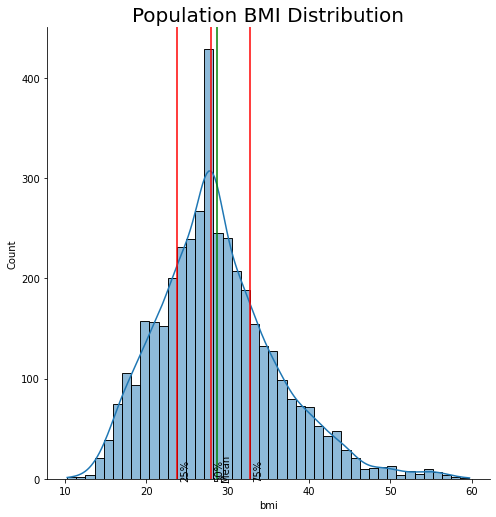

In [99]:
plot_continuous_variable_distribution(stroke_df_copy, stroke_df_copy.bmi, "bmi", "Population BMI Distribution")

Now we have more people with a bmi closer to 30, falling in the overweight category.

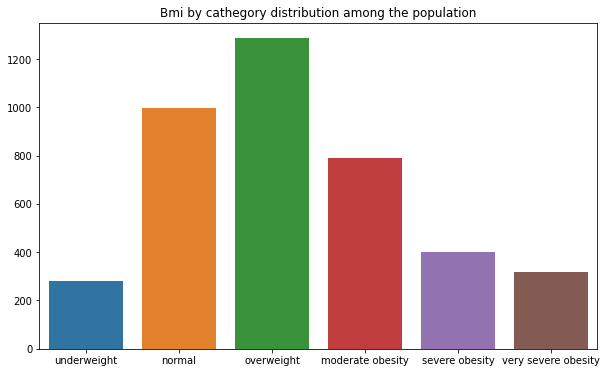

In [100]:
new_stroke_df_with_bmi_categ = stroke_df_copy.copy()
new_stroke_df_with_bmi_categ.bmi = pd.cut(new_stroke_df_with_bmi_categ.bmi,
                                      bins=[0, 18.5, 25, 30, 35, 40, 100],
                                      labels=bmi_categ_list)

bmi_categ_value_counts = new_stroke_df_with_bmi_categ.bmi.value_counts()

plt.figure(figsize=(10,6))
plt.title("Bmi by cathegory distribution among the population")
sns.barplot(x=bmi_categ_value_counts.index, y=bmi_categ_value_counts.array, order=bmi_categ_list)
plt.show()

Also the ratio of people that had a stroke has increased for the overweight category, since some people that had a missing bmi also had a stroke.

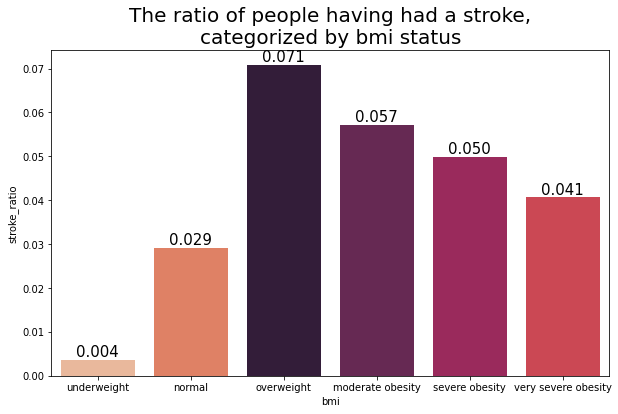

In [101]:
plot_categorical_variable_stroke_ratio(new_stroke_df_with_bmi_categ, "bmi", 
                                       "The ratio of people having had a stroke,\ncategorized by bmi status",3)

#### Smoking Status

###### The smoking status of children and teenagers




Other studies have shown that the earliest age when children start smoking is ~12 years old.

Resources:


*   [study on researchgate](https://www.researchgate.net/figure/Smoking-prevalence-by-gender-and-age-among-12-to-17-year-old-adolescents-in-Germany_fig2_251235344)
*   [CDC study](https://www.cdc.gov/tobacco/data_statistics/fact_sheets/youth_data/tobacco_use/index.htm)
*   [statcan.gc.ca](https://www150.statcan.gc.ca/n1/pub/82-625-x/2020001/article/00003-eng.htm)



In [102]:
children_df = stroke_df_copy[stroke_df_copy.age < 18].copy()
children_df.age = children_df.age.round()
children_age_smoking_categories = children_df.groupby(['age', 'smoking_status'])
children_age_smoking_categories_df = children_age_smoking_categories.size().reset_index(name='counts')
children_age_smoking_categories_df

,age,smoking_status,counts
0,0.0,Unknown,16
1,1.0,Unknown,49
2,2.0,Unknown,77
3,3.0,Unknown,39
4,4.0,Unknown,28
5,5.0,Unknown,52
6,6.0,Unknown,21
7,7.0,Unknown,24
8,8.0,Unknown,45
9,9.0,Unknown,33


Text(0.5, 1.0, 'The smoking status of underage people, by age group')

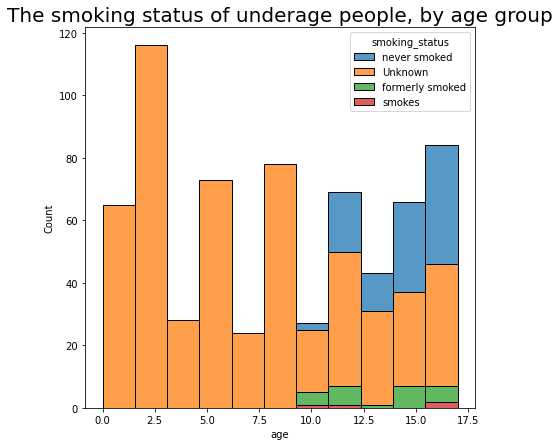

In [103]:
fig, ax = plt.subplots(figsize=def_fig_size)
sns.histplot(data=children_df, x="age", hue="smoking_status", ax=ax, multiple="stack")
plt.title("The smoking status of underage people, by age group", size = def_title_size)

The above table summarizes the number of childrean in each age + smoking_status group.

Observations:


*   all children below the age of 10 are reported with the status 'Unknown'. It seems safe to assume that these children in fact never smoked, so we cna replace their status with 'never smoked'
*   the youngest smokers that appear are 10 years old


In [104]:
# replace the smoking status of <10 years old children with 'never smoked'
stroke_df_copy.smoking_status = np.where(np.logical_and(stroke_df_copy.age < 10, stroke_df_copy.smoking_status == 'Unknown'), "never smoked", stroke_df_copy.smoking_status)

In [105]:
# New plots after the replacement
smoking_value_counts = stroke_df_copy.smoking_status.value_counts()
smoking_value_counts

never smoked       1880
Unknown             859
formerly smoked     713
smokes              622
Name: smoking_status, dtype: int64

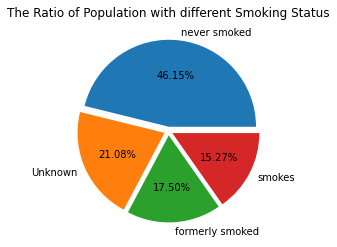

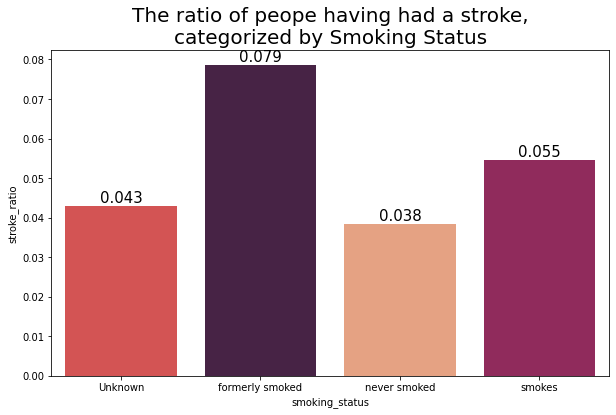

In [106]:
explode = [0.05] * smoking_value_counts.count()
plt.pie(smoking_value_counts.array, labels=smoking_value_counts.index, autopct = '%0.2f%%', explode = explode)
plt.title("The Ratio of Population with different Smoking Status")
plt.show()
plot_categorical_variable_stroke_ratio(stroke_df_copy, "smoking_status", "The ratio of peope having had a stroke,\ncategorized by Smoking Status", 3)

###### Handling 'Unknown' values

Still, **21.09% of the entries have their smoking_status 'Unknown'**. We considered the following **options for replacing them**:


1.   replace with the most frequent value, i.e. 'never smoked'
2.   replace with a random value (possibly with the previous/next known value in the dataframe)
3.   build a model to predict the smoking_status of the entries with missing data

It is clear, that option 1 and 2 are "blind replacements". We discarded the idea of applying any of these to options because:


*   based on the above plot, showing the ratio of people who suffered a stroke in each smoking_status category, it seems like the smoking_status has a significant impact in the tendency to have a stroke
*   the entries with 'Unknown' smoking status represent >20%, a huge portion of the data, 

so replacing the 'Unknown' values with incorrect values may introduce a significant error in our future predictions.

So, let's try to build a cost-efficient, simple RandomForestClassifier for option 3 and see how well it works. If it works with a high f1 score, we can consider replacing the 'Unknwon' values with the predictions of the DecisionTreeClassifier. Otherwise, we should just work with 'Unknown' as a separate category.




In [107]:
smoke_df = stroke_df_copy.copy()
smoke_df = smoke_df[smoke_df.smoking_status != 'Unknown']
X = smoke_df[smoke_df.columns.drop(['smoking_status', 'stroke', 'id'])].copy()
y = smoke_df.smoking_status
smoke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
845,25283,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked,0
3744,43734,Male,15.0,0,0,No,Private,Rural,122.25,21.0,never smoked,0
4183,47113,Female,67.0,0,0,Yes,Self-employed,Rural,110.42,24.9,never smoked,0
3409,56996,Male,44.0,0,0,Yes,Private,Urban,65.41,24.8,smokes,0
4796,67159,Male,73.0,1,0,No,Govt_job,Urban,71.29,37.7,never smoked,0


In [108]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [109]:
# handling categorical variables

# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

# apply one-hot encoder on them
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

OH_transformed_train = OH_encoder.fit_transform(X_train[object_cols])
OH_transformed_valid = OH_encoder.transform(X_valid[object_cols])

column_names = OH_encoder.get_feature_names_out(object_cols)

OH_cols_train = pd.DataFrame(OH_transformed_train, columns=column_names)
OH_cols_valid = pd.DataFrame(OH_transformed_valid, columns=column_names)

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

In [110]:
X_train

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban
4432,13.0,0,0,146.10,22.8,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4094,82.0,0,0,111.81,19.8,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4010,30.0,0,0,76.70,24.2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3203,46.0,0,0,66.59,36.7,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1317,0.8,0,0,98.67,17.5,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,3.0,0,0,101.30,24.8,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3133,16.0,0,0,87.16,28.2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2312,76.0,0,0,110.07,31.8,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3240,7.0,0,0,73.27,19.5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [111]:
for complexity in range(5,156,30):
  print("-------------------------------------------- Tree with max leav nodes = ", complexity)
  dt_classifier = RandomForestClassifier(criterion = "entropy", max_leaf_nodes = complexity)
  dt_classifier.fit(X_train, y_train)
  print("Accuracy: ", dt_classifier.score(X_valid, y_valid))
  y_valid_pred = dt_classifier.predict(X_valid)
  print(classification_report(y_valid, y_valid_pred))

-------------------------------------------- Tree with max leav nodes =  5
Accuracy:  0.5746268656716418
                 precision    recall  f1-score   support

formerly smoked       0.00      0.00      0.00       190
   never smoked       0.57      1.00      0.73       462
         smokes       0.00      0.00      0.00       152

       accuracy                           0.57       804
      macro avg       0.19      0.33      0.24       804
   weighted avg       0.33      0.57      0.42       804

-------------------------------------------- Tree with max leav nodes =  35


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.582089552238806
                 precision    recall  f1-score   support

formerly smoked       0.86      0.03      0.06       190
   never smoked       0.58      1.00      0.73       462
         smokes       0.00      0.00      0.00       152

       accuracy                           0.58       804
      macro avg       0.48      0.34      0.26       804
   weighted avg       0.54      0.58      0.44       804

-------------------------------------------- Tree with max leav nodes =  65


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.5733830845771144
                 precision    recall  f1-score   support

formerly smoked       0.33      0.02      0.03       190
   never smoked       0.58      0.99      0.73       462
         smokes       0.00      0.00      0.00       152

       accuracy                           0.57       804
      macro avg       0.30      0.34      0.25       804
   weighted avg       0.41      0.57      0.43       804

-------------------------------------------- Tree with max leav nodes =  95


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.5771144278606966
                 precision    recall  f1-score   support

formerly smoked       0.41      0.06      0.10       190
   never smoked       0.59      0.98      0.73       462
         smokes       0.00      0.00      0.00       152

       accuracy                           0.58       804
      macro avg       0.33      0.35      0.28       804
   weighted avg       0.43      0.58      0.45       804

-------------------------------------------- Tree with max leav nodes =  125
Accuracy:  0.582089552238806
                 precision    recall  f1-score   support

formerly smoked       0.45      0.11      0.17       190
   never smoked       0.59      0.97      0.73       462
         smokes       0.40      0.01      0.03       152

       accuracy                           0.58       804
      macro avg       0.48      0.36      0.31       804
   weighted avg       0.52      0.58      0.47       804

-------------------------------------------- Tree with max l

As we can see, the weighted F1-score barely reaches 0.5, so a simple RandomForestClassifier is not enough to accurately predict the smoking status of people. 

This is not a surprising finding actually: other than age, no feature allows us to make an assumption about the lifestyle of each person in the dataset, and we have already exploited the fact that small children are most probably non-smokers.

This makes it useless to try more complex and computationally more expensive ML models for predicting the smoking status of people.

**As a final conclusion, the 'Unknown' values will be treated as a 4. smoking_status category in the analysis.**

#### ID

Last but not least, we should drop the id column as we dont need it.

In [112]:
stroke_df_copy.drop(['id'], axis=1, inplace=True)
stroke_df_copy.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
845,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked,0
3744,Male,15.0,0,0,No,Private,Rural,122.25,21.0,never smoked,0
4183,Female,67.0,0,0,Yes,Self-employed,Rural,110.42,24.9,never smoked,0
3409,Male,44.0,0,0,Yes,Private,Urban,65.41,24.8,smokes,0
284,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,0


This is the final dataset that we achived after performing data cleaning.

### Building a Preprocessing Pipeline

The pipeline performs cleaning based on the approaches found above, and, additionaly, encodes the categorical variables.

#### Dropping outliers

Dropping rows cannot be integrated in the ColumnTranformers, so we'll implement this in a separate function.

In [113]:
class OutlierDropper(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):
        self.__drop_unknown_genders(df)
        self.__drop_bmi_outliers(df)

        return df
    
    def __drop_unknown_genders(self, df):
        df.drop(df[df['gender'] == 'Other'].index, inplace=True)

    def __drop_bmi_outliers(self, df):
        df.drop(df[df['bmi'] > 60].index, inplace=True)

#### Categorical variables

In [114]:
bin_categorical_cols = ['ever_married', 'residence_type', 'gender']
larger_categorical_cols = [cname for cname in stroke_df.columns if stroke_df[cname].dtype == "object" and cname not in bin_categorical_cols]
larger_categorical_cols

['work_type', 'smoking_status']

Based on the values of these variables, we can see that 'gender', 'ever_married' and 'residence_type' have just two possible values, so it's safe to assume an ordering between them, and assign 1 to one of the values and 0 to the other. This can be easily done using an OrdinalEncoder.

The other variables, 'work_type' and 'smoking_status' have multiple possible values with no ordering between them so we should apply a OneHotEncoder instead.

In [115]:
cat_var_transformers = [
    ('multi_cat', OneHotEncoder(), larger_categorical_cols),
    ('bin_cat', OrdinalEncoder(), bin_categorical_cols),
]

#### Numerical Variables

We only expect to have missing values in the BMI feature. As discussed above, a SimpleImputer with a median strategy is the most promising for BMI values, and for simplicity, we'll apply the same imputer for the other numerical columns as well.

In [116]:
# Select numerical columns
numerical_cols = [cname for cname in stroke_df.columns if stroke_df[cname].dtype in ['int64', 'float64']]
numerical_cols.remove('stroke')
numerical_cols

['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

In [117]:
num_var_transformers = [
    ('num_var', SimpleImputer(strategy='median'), numerical_cols)
]

#### ColumnTransformer integrating categoric and numeric variables

In [118]:
column_transformer = ColumnTransformer(
    transformers = cat_var_transformers + num_var_transformers,
    remainder = 'passthrough'
)

#### Resetting Feature Names of dataframe after ColumnTransformer

In [119]:
class ColumnTransformerFeatureNameResetter(BaseEstimator, TransformerMixin):
    def __init__(self, renamer_column_transformer, init_df):
        super().__init__()
        self.__renamer_column_transformer = renamer_column_transformer
        self.__init_df = init_df
        self.__columns = None

    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):

        df = pd.DataFrame(df)

        df.columns = self.__get_columns_from_transformer(self.__renamer_column_transformer, self.__init_df.columns)

        self.__columns = df.columns

        df[df.columns] = df[df.columns].apply(pd.to_numeric, errors='coerce')

        return df

    def get_columns(self):
        return self.__columns

    def __get_columns_from_transformer(self, column_transformer, input_colums):    
        """
        source: https://github.com/scikit-learn/scikit-learn/issues/12525#issuecomment-744424900
        """
        col_name = []

        for transformer_in_columns in column_transformer.transformers_[:-1]: #the last transformer is ColumnTransformer's 'remainder'
            raw_col_name = transformer_in_columns[2]
            if isinstance(transformer_in_columns[1],Pipeline): 
                transformer = transformer_in_columns[1].steps[-1][1]
            else:
                transformer = transformer_in_columns[1]
            try:
                names = transformer.get_feature_names_out(raw_col_name)
            except AttributeError: # if no 'get_feature_names' function, use raw column name
                names = raw_col_name
            if isinstance(names,np.ndarray): # eg.
                col_name += names.tolist()
            elif isinstance(names,list):
                col_name += names    
            elif isinstance(names,str):
                col_name.append(names)

        [_, _, reminder_columns] = column_transformer.transformers_[-1]

        for col_idx in reminder_columns:
            col_name.append(input_colums[col_idx])

        return col_name

#### Custom Transformers

In [120]:
class WorkTypeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):
        df['work_type'] = df.apply(
            lambda row: "children" if ((row['work_type'] == 'Never_worked') & (row['age'] < 18)) else row['work_type'],
            axis=1
        )

        return df

In [121]:
class SmokingStatusTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):
        df.smoking_status = np.where(np.logical_and(df.age < 10, df.smoking_status == 'Unknown'), "never smoked", df.smoking_status)

        return df

#### Scaling Values

It is known that most ML algorithms perform better if the features have similar scales, as it is the case in out dataframe: for example, BMI values have the range [0, 60], whereas avg_glucose_level values are in the interval [50, 270]. 

To overcome this issue, we should scale all the values. Since many of our variables do not follow a normal distribution but are rather skewed (see BMI - right skewed, or avg_glucose_level - doubles peaked), and we have many binary-values nominal variables as well marked with 0 or 1, we should use the MinMaxScaler instead of the StandardScaler.

In [122]:
scaler = MinMaxScaler()

In [123]:
class ScalerFeatureNameResetter(BaseEstimator, TransformerMixin):
    def __init__(self, renamer_scaler, init_cols):
        super().__init__()
        self.__renamer_scaler = renamer_scaler
        self.__init_cols = init_cols

    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):

        df = pd.DataFrame(df)

        df.columns = self.__renamer_scaler.get_feature_names_out(self.__init_cols)
        return df

#### Integrating all steps in a pipeline

In [124]:
column_transformer_name_resetter = ColumnTransformerFeatureNameResetter(column_transformer, stroke_df)

In [125]:
preprocesser_pipeline = Pipeline([
        ('drop_outliers', OutlierDropper()), 
        ('work_type_replacement_for_children', WorkTypeTransformer()), 
        ('smoking_status_replacement_for_small_children', SmokingStatusTransformer()), 
        ('column_processing', column_transformer),
        ('reset_feature_names', column_transformer_name_resetter),
        ('scaling', scaler),
        ('reset_scaled_feature_names', ScalerFeatureNameResetter(scaler, column_transformer_name_resetter.get_columns()))
])

In [126]:
processed_stroke_df = pd.DataFrame(preprocesser_pipeline.fit_transform(stroke_df))
processed_stroke_df

,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,ever_married,residence_type,gender,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.345937,0.584961,0.0,0.0,0.065045,0.461538,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.599166,0.182129,0.0,0.0,0.309898,0.216599,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.645540,0.816895,0.0,0.0,0.255286,0.295547,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.781178,0.536133,0.0,0.0,0.047503,0.293522,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.360238,0.169922,0.0,0.0,0.125658,0.431174,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4069,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.921455,0.548340,0.0,0.0,0.174222,0.502024,0.0
4070,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.470733,0.194336,0.0,0.0,0.269366,0.186235,0.0
4071,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.146508,0.743652,0.0,0.0,0.108623,0.524291,0.0
4072,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.050451,0.377441,0.0,0.0,0.087388,0.317814,0.0


#### Tests

In [127]:
new_work_type_value_counts = processed_stroke_df.work_type_Never_worked.sum()
new_work_type_value_counts

4.0

In [128]:
processed_stroke_df.isnull().sum()

work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
ever_married                      0
residence_type                    0
gender                            0
id                                0
age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
stroke                            0
dtype: int64

In [129]:
processed_stroke_df.smoking_status_Unknown.value_counts()

0.0    3215
1.0     859
Name: smoking_status_Unknown, dtype: int64

In [130]:
processed_stroke_df.gender.value_counts()

0.0    2386
1.0    1688
Name: gender, dtype: int64

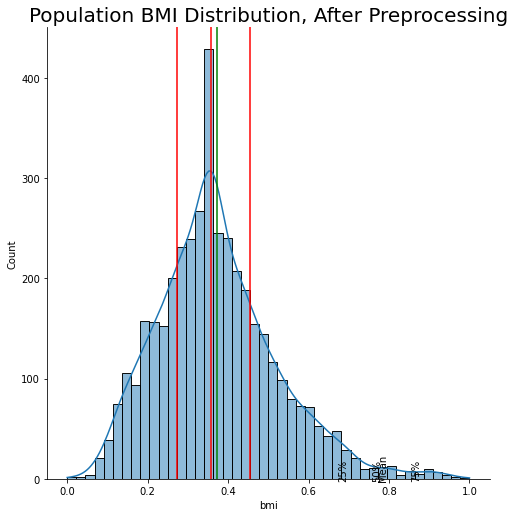

In [131]:
plot_continuous_variable_distribution(processed_stroke_df, processed_stroke_df.bmi, "bmi", "Population BMI Distribution, After Preprocessing")

In [132]:
# find categorical variables
categorical_cols = [cname for cname in processed_stroke_df.columns if processed_stroke_df[cname].dtype == "object"]
categorical_cols

[]

In [133]:
processed_test_stroke_df = pd.DataFrame(preprocesser_pipeline.fit_transform(stroke_test_df))
processed_test_stroke_df

,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,ever_married,residence_type,gender,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.331666,0.768066,0.0,0.0,0.108170,0.491266,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.906141,0.523926,0.0,0.0,0.147916,0.458515,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.714892,0.279785,0.0,0.0,0.336284,0.358079,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.653314,0.255371,0.0,0.0,0.720085,0.275109,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.669433,0.816895,0.0,0.0,0.273511,0.305677,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.536671,1.000000,0.0,0.0,0.126913,0.299127,0.0
1018,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.672292,0.414062,0.0,0.0,0.305157,0.451965,0.0
1019,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.375366,0.609375,0.0,0.0,0.173723,0.185590,0.0
1020,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.496599,0.182129,0.0,0.0,0.034424,0.436681,0.0
